In [1]:
# data handling libraries
import pandas as pd
import numpy as np

# custom utility functions 
import functions as fn

# Suppress warnings and set float formatting
import warnings
warnings.filterwarnings("ignore")

# Format float display in dataframes to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [2]:
# Load CSV datasets
flights = pd.read_csv(r'C:\Users\RadhaPulipati\capitalone_data_challenge\data\Flights.csv', low_memory=False)
tickets = pd.read_csv(r'C:\Users\RadhaPulipati\capitalone_data_challenge\data\Tickets.csv', low_memory=False)
airports = pd.read_csv(r'C:\Users\RadhaPulipati\capitalone_data_challenge\data\Airport_Codes.csv', low_memory=False)

In [3]:
# Filter data for valid (non-canceled, round trip) and relevant airports
flights = flights[flights['CANCELLED'] == 0]
tickets = tickets[tickets['ROUNDTRIP'] == 1]

airports = airports[
    (airports['ISO_COUNTRY'] == 'US') & 
    (airports['TYPE'].isin(['medium_airport', 'large_airport']))
]

In [4]:
#summary_statistics() function from custom function.py fn module)
#Prints descriptive statistics for each dataset
print(fn.summary_statistics(flights),fn.summary_statistics(tickets),fn.summary_statistics(airports))

(FL_DATE              1864272
OP_CARRIER           1864272
TAIL_NUM             1864272
OP_CARRIER_FL_NUM    1864272
ORIGIN_AIRPORT_ID    1864272
ORIGIN               1864272
ORIGIN_CITY_NAME     1864272
DEST_AIRPORT_ID      1864272
DESTINATION          1864272
DEST_CITY_NAME       1864272
DEP_DELAY            1864272
ARR_DELAY            1859895
CANCELLED            1864272
AIR_TIME             1859245
DISTANCE             1863662
OCCUPANCY_RATE       1863962
dtype: int64, FL_DATE               object
OP_CARRIER            object
TAIL_NUM              object
OP_CARRIER_FL_NUM     object
ORIGIN_AIRPORT_ID      int64
ORIGIN                object
ORIGIN_CITY_NAME      object
DEST_AIRPORT_ID        int64
DESTINATION           object
DEST_CITY_NAME        object
DEP_DELAY            float64
ARR_DELAY            float64
CANCELLED            float64
AIR_TIME              object
DISTANCE              object
OCCUPANCY_RATE       float64
dtype: object,        ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID 

In [5]:
# Removes duplicate rows from flights, tickets, and airports datasets using custom (function.py) fn module returns log counts
flights = fn.find_and_remove_duplicates(flights, "Flights")
tickets = fn.find_and_remove_duplicates(tickets, "Tickets")
airports = fn.find_and_remove_duplicates(airports, "Airports")

Flights - Total Rows Before Cleaning: 1864272
Flights - Duplicate Rows Found: 4410
Flights - Total Rows After Removing Duplicates: 1859862
Tickets - Total Rows Before Cleaning: 708600
Tickets - Duplicate Rows Found: 47564
Tickets - Total Rows After Removing Duplicates: 661036
Airports - Total Rows Before Cleaning: 858
Airports - Duplicate Rows Found: 0
Airports - Total Rows After Removing Duplicates: 858


In [6]:
# Drop irrelevant columns to focus analysis on key metrics
flights=flights.drop(['OP_CARRIER','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','CANCELLED','AIR_TIME'],axis=1)
tickets=tickets.drop(['ITIN_ID','YEAR', 'QUARTER', 'ORIGIN_COUNTRY', 'ORIGIN_STATE_ABR', 'REPORTING_CARRIER', 'ORIGIN_STATE_NM'],axis=1)
airports=airports.drop(['CONTINENT','ISO_COUNTRY','MUNICIPALITY','ELEVATION_FT'],axis=1)

In [7]:
# Data types formatting from object into appropriate numerical and datetime formats.
fn.to_number(flights,['DISTANCE'])
fn.to_number(tickets,['ITIN_FARE'])

#Convert date from object to date
flights['FL_DATE'] = pd.to_datetime(flights['FL_DATE'], format='mixed', dayfirst=False)

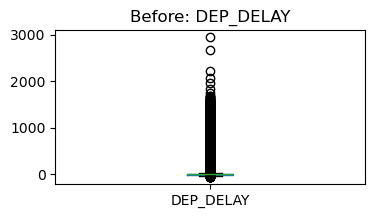

DEP_DELAY - Lower (1.0%): -15.0, Upper (99.0%): 202.0


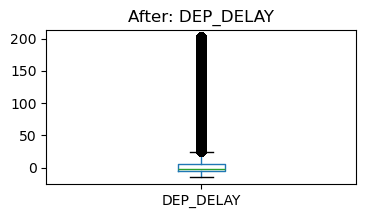

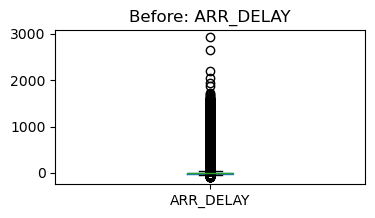

ARR_DELAY - Lower (1.0%): -38.0, Upper (99.0%): 202.0


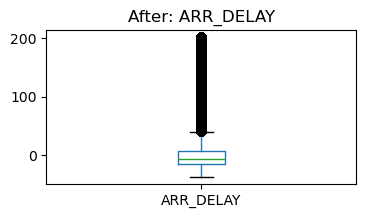

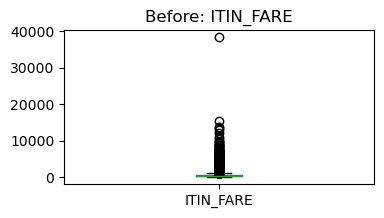

ITIN_FARE - Lower (1.0%): 11.0, Upper (95.0%): 1024.0


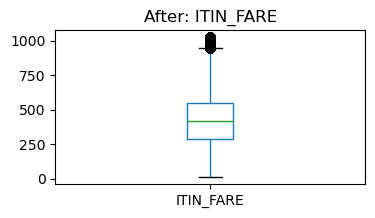

In [8]:
#  Removes outliers from flight delays (1%-99% percentile) and ticket fares (1%-95%) using custom (function.py) fn module.
flights = fn.remove_outliers(flights, ['DEP_DELAY', 'ARR_DELAY'], 0.01, 0.99, plot=True)
tickets = fn.remove_outliers(tickets, ['ITIN_FARE'], 0.01, 0.95, plot=True)

In [9]:
# Exclude rows where object data type is missing and numeric replace with median
flights, flights_summary = fn.clean_nan_data(flights)
tickets, tickets_summary = fn.clean_nan_data(tickets)
airports, airports_summary = fn.clean_nan_data(airports)

# Print summaries
print("\n".join(flights_summary))
print("\n".join(tickets_summary))
print("\n".join(airports_summary))

Filled 268 nulls in numeric column 'DISTANCE' with median value 612.0.
Filled 31 nulls in numeric column 'OCCUPANCY_RATE' with median value 0.65.
Filled 960 nulls in numeric column 'PASSENGERS' with median value 1.0.
Dropped 37 rows due to nulls in object column 'IATA_CODE'.


In [10]:
# Final Verification of data integrity after cleaning - to check consistent row counts and summary stats across all datasets
#print (fn.summary_statistics(flights),"\n", fn.summary_statistics(tickets), "\n", fn.summary_statistics(airports))

## Merging and Transforming datasets:

- Tickets Data: Created a consistent ROUTE identifier by sorting origin/destination IATA codes alphabetically (e.g., JFK-LAX for both JFK→LAX and LAX→JFK).
- Flights Data: Applied the same sorting logic to ensure bidirectional routes are treated identically.
- Calculated median fares per route, accounting for ticket frequency to better represent revenue potential.
- Enriched flight data with airport types (medium_airport/large_airport) by merging:
- Once for origins (added as ORIGIN_TYPE)
- Once for destinations (added as DESTINATION_TYPE)
- Combined flight data with aggregated ticket statistics using the standardized ROUTE key.
- Used a left join to preserve all flights even if ticket data was missing (though filtered later for round-trip pairs)

## New field with metadata description

- Route: Combines the ORIGIN and DESTINATION airport codes into a standardized route string, sorted alphabetically and separated by a hyphen. This ensures that the route identifier is consistent regardless of flight direction (ATL-JFK is the same as JFK-ATL).
- Data Type: String



In [13]:
#consistent route identifiers for tickets
tickets['ROUTE'] = tickets.apply(lambda x: '-'.join(sorted([x['ORIGIN'], x['DESTINATION']])), axis=1)

In [14]:
ticket_stats =tickets.groupby('ROUTE').agg({'ITIN_FARE': np.median}).reset_index().\
                                                            rename(columns={'ITIN_FARE': 'ITIN_FARE_MEDIAN'})

In [15]:
airports = airports[['IATA_CODE', 'TYPE', 'COORDINATES']]
flights = flights.merge(airports, left_on='ORIGIN', right_on='IATA_CODE', how='inner', suffixes=('', '_origin')).rename(columns={\
    'TYPE': 'ORIGIN_TYPE', 'COORDINATES': 'ORIGIN_COORDINATES'})

flights = flights.merge(airports, left_on='DESTINATION', right_on='IATA_CODE', how='inner', suffixes=('', '_destination')).rename(columns={\
    'TYPE': 'DESTINATION_TYPE', 'COORDINATES': 'DESTINATION_COORDINATES'})

flights = flights.drop(columns=['IATA_CODE','TAIL_NUM', 'IATA_CODE_destination'], errors='ignore')

In [16]:
#Create consistent route identifiers for flights
flights['ROUTE'] = flights.apply(lambda x: '-'.join(sorted([x['ORIGIN'], x['DESTINATION']])), axis=1)

In [17]:
flights = flights.merge(ticket_stats, on='ROUTE', how='left')

# Calculated fields for Costs Analysis

In [19]:
# Estimate Passenger Count from Occupancy Rate
flights['PASSENGERS']= flights['OCCUPANCY_RATE'].apply(fn.number_of_passengers)

In [20]:
# --- Delay Costs ---
# Compute delay-related costs based on arrival and departure delays.
# First 15 minutes are free; $75 charged per minute beyond that per delay type.

flights['ARR_DELAY_COSTS']= flights['ARR_DELAY'].apply(fn.delay_costs)
flights['DEP_DELAY_COSTS']= flights['DEP_DELAY'].apply(fn.delay_costs)

flights['TOTAL_DELAY_COST'] = flights['DEP_DELAY_COSTS'] + flights['ARR_DELAY_COSTS']

In [21]:
# --- Airport Costs ---
# Calculate fixed airport operational fees per round trip.
# Large airports incur $10,000 per landing, medium airports $5,000.

flights['ORIGIN_AIRPORT_COST'] = np.where(flights['ORIGIN_TYPE'] == 'large_airport', 10000, 5000)
flights['DEST_AIRPORT_COST'] = np.where(flights['DESTINATION_TYPE'] == 'large_airport', 10000, 5000)
flights['AIRPORT_COSTS'] = flights['ORIGIN_AIRPORT_COST'] + flights['DEST_AIRPORT_COST']

In [22]:
# --- Fuel, Oil, Maintenance, Crew Costs,Depreciation, Insurance, Other Costs---
# Distance-based variable costs calculated at $8 per mile.
# Additional distance-based costs calculated at $1.18 per mile.
# Combined with the above to form total mileage-related operational expenses.

flights['MILEAGE_COSTS']= flights['DISTANCE'].apply(fn.costs_per_mile)

In [23]:
# --- Revenue Calculations ---
# Estimate total revenue per flight from two components:
# 1. Ticket Revenue – based on median fare and estimated passengers using occupancy rate.
# 2. Baggage Revenue – assumes 50% of passengers check one bag at $35 per leg (round trip = 2 legs).

flights['BAGGAGE_REVENUE'] = flights['PASSENGERS'] * 35 * 0.5 * 2 #For round trip
flights['TICKET_REVENUE'] = flights['PASSENGERS']*flights['ITIN_FARE_MEDIAN']
flights['TOTAL_REVENUE'] = flights['TICKET_REVENUE'] + flights['BAGGAGE_REVENUE']

In [24]:
# Calculate total cost and revenue per flight    

flights['TOTAL_COSTS']= (flights['TOTAL_DELAY_COST']+flights['AIRPORT_COSTS']+flights['MILEAGE_COSTS'])
flights['TOTAL_PROFIT'] = flights['TOTAL_REVENUE'] - flights['TOTAL_COSTS']
                                  
flights['PROFIT_PER_FLIGHT'] = flights['TOTAL_PROFIT']/flights.groupby('ROUTE')['ROUTE'].transform('count')


In [25]:
flights['ROUND_TRIP'] = flights.apply(lambda x: '-'.join(sorted([x['ORIGIN_CITY_NAME'], x['DEST_CITY_NAME']])), axis=1)

## Metric-Based Data Categorization

In [27]:
# Count actual round trips by finding matching outbound/return flights on same date
round_trip_flights = flights.groupby(['ROUTE', 'FL_DATE']).filter(lambda x: len(x['ORIGIN'].unique()) == 2)

In [28]:
# --- Aggregate by ROUND_TRIP route ---
route_summary = round_trip_flights.groupby('ROUTE').agg({
    'TOTAL_PROFIT': 'sum',
    'TOTAL_REVENUE': 'sum',
    'TOTAL_COSTS': 'sum',
    'TICKET_REVENUE': 'sum',
    'BAGGAGE_REVENUE': 'sum',
    'PASSENGERS': 'sum',
    'DISTANCE': 'mean',
    'TOTAL_DELAY_COST': 'sum',
    'DEP_DELAY_COSTS': 'sum',
    'ARR_DELAY_COSTS': 'sum',
    'MILEAGE_COSTS': 'sum',
    'AIRPORT_COSTS': 'sum',
    'FL_DATE': 'count',
    'PROFIT_PER_FLIGHT': 'mean',
    'DEP_DELAY': 'mean',
    'ARR_DELAY': 'mean',
    'ITIN_FARE_MEDIAN': 'mean',
    'OCCUPANCY_RATE': 'mean'   
}).reset_index().rename(columns={
    'FL_DATE': 'FLIGHT_COUNT',
    'DEP_DELAY': 'AVG_DEP_DELAY',
    'ARR_DELAY': 'AVG_ARR_DELAY',
}).reset_index()

## Additional metrics

In [30]:
# return on investment
route_summary['ROI'] = (route_summary['TOTAL_PROFIT']/route_summary['TOTAL_COSTS'])*100
route_summary['LOAD_FACTOR'] = (route_summary['PASSENGERS'] / (200 * route_summary['FLIGHT_COUNT'])) * 100
route_summary['RASM'] = route_summary['TOTAL_REVENUE'] / (200 * route_summary['DISTANCE'] * route_summary['FLIGHT_COUNT'])
route_summary['CASM'] = route_summary['TOTAL_COSTS'] / (200 * route_summary['DISTANCE'] * route_summary['FLIGHT_COUNT'])

# Question 1: Top 10 Busiest Round-Trip Routes (by Flight Count)

- This analysis identifies the top 10 round-trip city pairs with the highest number of completed (non-canceled) flights in Q1 2019.
- It provides insight into the most frequently operated routes, helping to gauge travel demand and inform resource allocation.
- Only active flights are considered, ensuring the focus remains on actual operational performance.

In [32]:
# Count flights for each round trip route
top_busiest_routes = route_summary.sort_values('FLIGHT_COUNT', ascending=False).head(10)

print("Top 10 Busiest Round Trip Routes in 1st quarter:\n", top_busiest_routes[['ROUTE', 'FLIGHT_COUNT']])


Top 10 Busiest Round Trip Routes in 1st quarter:
         ROUTE  FLIGHT_COUNT
2140  LAX-SFO          8340
2180  LGA-ORD          7156
2045  LAS-LAX          6511
1989  JFK-LAX          6320
2139  LAX-SEA          4999
542   BOS-LGA          4820
1751  HNL-OGG          4794
2590  PDX-SEA          4774
189   ATL-MCO          4707
185   ATL-LGA          4594


## Question 2: Top 10 most profitable round trip routes
This analysis ranks the top 10 round-trip routes by total profit during the first quarter of 2019, excluding canceled flights and upfront airplane costs. Profit is calculated by subtracting total operational costs (e.g., fuel, delays, airport fees, depreciation) from total revenue (ticket sales and baggage fees). The output includes each route’s total revenue, total cost, total profit, and number of completed flights.

In [34]:
profitable_routes = route_summary.sort_values('TOTAL_PROFIT', ascending=False).head(10)
 
print("\nTop 10 Most Profitable Round Trip Routes in 1st quarter:\n")
print(profitable_routes[['ROUTE', 'TOTAL_PROFIT', 'TOTAL_REVENUE', 'TOTAL_COSTS', 'FLIGHT_COUNT']])
                                                                                            


Top 10 Most Profitable Round Trip Routes in 1st quarter:

        ROUTE  TOTAL_PROFIT  TOTAL_REVENUE  TOTAL_COSTS  FLIGHT_COUNT
1117  DCA-ORD  152808294.80   252095571.00  99287276.20          3695
131   ATL-CLT  135134828.32   204783444.00  69648615.68          3076
1101  DCA-LGA  127816979.32   207374552.00  79557572.68          3359
838   CLT-GSP  126039000.50   159176160.00  33137159.50          1547
2140  LAX-SFO  120960920.60   330178970.00 209218049.40          8340
542   BOS-LGA  120096223.60   234032882.00 113936658.40          4820
2406  MSP-ORD  119294676.20   203440104.00  84145427.80          3440
2180  LGA-ORD  115301051.36   321442996.00 206141944.64          7156
140   ATL-DCA  113291083.52   202820886.00  89529802.48          3488
1290  DFW-IAH  111553331.40   180050832.00  68497500.60          2955


### High Profitable Round Trip Routes Summary:
These routes showed the highest total profits in Q1 and should be prioritized for continued investment and optimization:

- DCA-ORD – 152.8M profit across 3,695 flights
- ATL-CLT – 135.1M profit with strong ROI
- DCA-LGA – 127.8M profit consistently strong performer
- CLT-GSP – 126M profit and also a recommended investment route

## Question 3: Recommend 5 Best Routes to Invest In
This analysis identifies the most promising U.S. domestic round trip flight routes for investment, based on Q1 2019 operational data. The goal is to select 5 optimal routes for launching new services using dedicated aircraft, with a strong focus on profitability and punctuality.

*key factors considered with combined score metrics:*
- Return on Investment (ROI): Measures how efficiently each route converts operating costs into profit. (40% weight)
- Total Profit: Captures overall earnings from each route in the quarter. (30% weight)
- Flight Volume: Indicates demand and scalability potential. (10% weight)
- Average Delays: Reflects punctuality, a critical factor aligned with the airlines ,"On time, for you" brand. (20% weight)

In [37]:
route_summary['COMBINED_SCORE'] = (
    0.4 * route_summary['ROI'] / route_summary['ROI'].max() +
    0.3 * route_summary['TOTAL_PROFIT'] / route_summary['TOTAL_PROFIT'].max() +
    0.2 * (1 - (route_summary['AVG_DEP_DELAY'] + route_summary['AVG_ARR_DELAY']) / (route_summary['AVG_DEP_DELAY'].max() + route_summary['AVG_ARR_DELAY'].max())) +
    0.1 * route_summary['FLIGHT_COUNT'] / route_summary['FLIGHT_COUNT'].max()
)

recommended_routes = route_summary.sort_values('COMBINED_SCORE', ascending=False).head(5)

print("\nTop 5 Recommended Routes to Invest In:")
print(recommended_routes[['ROUTE','COMBINED_SCORE','ROI', 'TOTAL_PROFIT', 'FLIGHT_COUNT', 'AVG_DEP_DELAY','AVG_ARR_DELAY']])


Top 5 Recommended Routes to Invest In:
        ROUTE  COMBINED_SCORE    ROI  TOTAL_PROFIT  FLIGHT_COUNT  \
2294  MDT-PHL            0.77 631.58   83918469.84           793   
838   CLT-GSP            0.70 380.36  126039000.50          1547   
846   CLT-ILM            0.68 409.24  103787857.50          1465   
873   CLT-MYR            0.65 401.21   91866162.96          1354   
837   CLT-GSO            0.64 338.80  107784698.22          1487   

      AVG_DEP_DELAY  AVG_ARR_DELAY  
2294           3.67           3.69  
838            5.20          -1.83  
846            3.72          -1.18  
873            1.96          -3.84  
837            3.52          -2.59  


### Top 5 Recommended Routes Summary:
These routes show strong ROI, high profitability per flight, and relatively low average delays:

- MDT-PHL – Highest ROI (631.58%), low delays, breakeven best case at just 708 flights
- CLT-GSP – High combined score (0.70), profitable, already among top 10 routes
- CLT-ILM – Strong ROI (409.24%), good profit with minimal delay
- CLT-MYR – Excellent ROI and very low arrival delays (-3.84 mins avg)
- CLT-GSO – Over $100M in profit with reliable on-time performance

## Question 4: # Breakeven round-trip flights on the upfront airplane cost 
This analysis calculates the number of flights required for 5 recommended round-trip airline routes to breakeven on an upfront airplane cost of $90M. It considers:

- Added sensitivity analysis showing best-case/worst-case scenarios  (+20%, -20%)
- Risk AssessmentHelps assess financial risk under different scenarios.
- Accounts for potential variability in profit per flight

In [40]:
# Calculate breakeven metrics
airplane_cost = 90000000 

# Calculate profit per flight safely (handle division by zero)
route_summary['PROFIT_PER_FLIGHT'] = (route_summary['TOTAL_PROFIT'] / route_summary['FLIGHT_COUNT']).replace(0, np.nan)
route_summary['BREAKEVEN_FLIGHTS'] = (airplane_cost / route_summary['PROFIT_PER_FLIGHT'])

# Sensitivity analysis (best/worst case)
route_summary['BEST_CASE_PROFIT'] = route_summary['PROFIT_PER_FLIGHT'] * 1.2  # 20% higher
route_summary['WORST_CASE_PROFIT'] = route_summary['PROFIT_PER_FLIGHT'] * 0.8  # 20% lower

route_summary['BREAKEVEN_BEST_CASE'] = (airplane_cost / route_summary['BEST_CASE_PROFIT'])
route_summary['BREAKEVEN_WORST_CASE'] = (airplane_cost / route_summary['WORST_CASE_PROFIT'])

route_summary = route_summary.sort_values('PROFIT_PER_FLIGHT', ascending=False).head(5)

# Display results
print("\nBreakeven Analysis for Recommended Routes:")
cols_to_show = ['ROUTE', 'PROFIT_PER_FLIGHT', 'BREAKEVEN_FLIGHTS', 'BREAKEVEN_BEST_CASE', 'BREAKEVEN_WORST_CASE']
print(route_summary[cols_to_show].to_string())


Breakeven Analysis for Recommended Routes:
        ROUTE  PROFIT_PER_FLIGHT  BREAKEVEN_FLIGHTS  BREAKEVEN_BEST_CASE  BREAKEVEN_WORST_CASE
2294  MDT-PHL          105824.05             850.47               708.72               1063.09
1067  DAY-DTW           92799.87             969.83               808.19               1212.29
1251  DEN-SUN           87271.25            1031.27               859.39               1289.08
838   CLT-GSP           81473.17            1104.66               920.55               1380.82
1962  ISP-PHL           80871.52            1112.88               927.40               1391.10


### Breakeven Analysis for Recommended Routes Summary:
The following routes show favorable breakeven flight volumes, indicating high feasibility for reaching profitability quickly:

- MDT-PHL – Breaks even in as few as 708 flights (best case)
- CLT-GSP – Breaks even in 920 to 1,380 flights
- DEN-SUN, DAY-DTW, and ISP-PHL – All show high per-flight profitability and manageable breakeven thresholds

In [42]:
#------------------------------------------------KPI &Summary--------------------------------------------------

## Question 5: Key Performance Indicators (KPIs) for Round Trip Routes

- Load Factor (passenger capacity utilization)
- RASM (Revenue per Available Seat Mile)
- CASM (Cost per Available Seat Mile)
- OnTime Performance metrics


In [44]:
print("Average Load Factor:", route_summary['LOAD_FACTOR'].mean(), "%")

Average Load Factor: 65.00432666783888 %


In [45]:
print("Average RASM (Revenue per Available Seat Mile):", route_summary['RASM'].mean())

Average RASM (Revenue per Available Seat Mile): 4.4743746668083615


In [46]:
print("Average CASM (Cost per Available Seat Mile):", route_summary['CASM'].mean())

Average CASM (Cost per Available Seat Mile): 0.7904507207321467


In [47]:
#On-time Performance (Departure and Arrival Delays)
on_time_departure = (flights['DEP_DELAY'] <= 15).mean() * 100
on_time_arrival = (flights['ARR_DELAY'] <= 15).mean() * 100

print(f"On-Time Departure Rate: {on_time_departure:.2f}%")
print(f"On-Time Arrival Rate: {on_time_arrival:.2f}%")

On-Time Departure Rate: 82.96%
On-Time Arrival Rate: 81.98%


## Recommendations:
- Invest in top-scoring routes with strong ROI and fast breakeven potential, especially MDT-PHL and CLT regional routes.
- Maintain and expand service on high-profit legacy routes, such as DCA-ORD and ATL-CLT, to secure continued revenue growth.
- Leverage CLT as a strategic hub, focusing on regional connectivity to maximize profitability and route efficiency.

## Conclusion:

Investing in data-driven, high-performing routes with strong profitability and operational efficiency will strengthen financial returns. Focused expansion around proven hubs like CLT, alongside disciplined performance tracking, will ensure sustainable and scalable route growth.
## Key Metrics for Success
Monitoring effectively Key Performance Indicators (KPIs): Tableau Market Analysis Dashboard
- Total Revenue per Route: Measures the overall income generated by each route.
- Total Costs per Route: Tracks all operational expenses associated with each route.
- Profit Margin per Route: (Total Revenue - Total Costs) / Total Revenue, indicating the profitability of each route.
- Return on Investment (ROI) per Route: (Total Profit / Total Costs) * 100, assessing the efficiency of capital utilization.
- On-Time Performance (Departure & Arrival): Percentage of flights departing and arriving within 15 minutes of the scheduled time.

By consistently monitoring these KPIs, the airline can gain valuable insights into the financial viability, operational efficiency, and customer perception of each route. This data-driven approach will enable informed decisions regarding route adjustments, marketing efforts, and overall strategic direction to ensure sustainable and profitable growth in the US domestic market.